Import Data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_stata("callreports_final.dta", chunksize=100000, preserve_dtypes=True)

df_raw = pd.DataFrame()

for chunk in data:
    df_raw=df_raw.append(chunk)

Additional Settings

In [3]:
%matplotlib inline
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.ticker as ticker

pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 18

plt.style.use('ggplot')


plt.rcParams['font.size']=BIGGER_SIZE          # controls default text sizes
plt.rcParams['axes.titlesize']=BIGGER_SIZE     # fontsize of the axes title
plt.rcParams['axes.labelsize']=BIGGER_SIZE    # fontsize of the x and y labels
plt.rcParams['xtick.labelsize']=BIGGER_SIZE    # fontsize of the tick labels
plt.rcParams['ytick.labelsize']=BIGGER_SIZE    # fontsize of the tick labels
plt.rcParams['legend.fontsize']=BIGGER_SIZE    # legend fontsize
plt.rcParams['figure.titlesize']=BIGGER_SIZE  # fontsize of the figure title

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#removing Goldman Sachs and Morgan Stanley
df_raw = df_raw[(df_raw.rssdid!=1456501) & (df_raw.bhcid!=2380443)]

Leverage Ratio: L = Assets/Equity (Commercial banks aggregated by bhc)

In [4]:
df = df_raw[["name", "bhcid", "rssdid","assets",'year', "quarter", "equity"]]
#df = df[df.quarter==4]
df_indBanks = df[df.bhcid == 0]
df = df[df.bhcid != 0]
df = df.groupby(["bhcid","year", "quarter"]).agg({"assets":"sum",
                                  "equity":"sum"})

df["leverageRatio"] = df.assets/df.equity 
df.index.names = ["rssdid", "year", "quarter"]
df_indBanks["leverageRatio"] = df_indBanks.assets/df_indBanks.equity
df_indBanks.set_index([df_indBanks.rssdid, df_indBanks.year, df_indBanks.quarter], inplace=True)
df_indBanks = df_indBanks[["rssdid","bhcid", "year", "quarter", "assets", "equity", "leverageRatio", "name"]]
df_indBanks.drop(["rssdid", "bhcid", "year", "quarter"], axis=1, inplace=True)
#df
df_all = pd.concat([df, df_indBanks])

print(df.head)

print(df_indBanks)

print(df_all)
#fig, ax = plt.subplot()
#ax.plot()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


<bound method NDFrame.head of                              assets    equity  leverageRatio
rssdid    year   quarter                                    
128146.0  1976.0 1.0        10986.0     956.0      11.491632
                 2.0        11870.0    1030.0      11.524272
                 3.0        11410.0    1061.0      10.754006
                 4.0        11559.0    1049.0      11.019066
          1977.0 1.0        11936.0    1068.0      11.176030
...                             ...       ...            ...
4534101.0 2013.0 4.0       145922.0   15876.0       9.191358
4552356.0 2013.0 4.0        89248.0   10119.0       8.819844
4553960.0 2013.0 4.0       412436.0   43104.0       9.568393
4556381.0 2013.0 4.0       123832.0   14899.0       8.311430
4558901.0 2013.0 4.0      1323371.0  121814.0      10.863866

[718158 rows x 3 columns]>
                            assets    equity  leverageRatio                  name
rssdid    year   quarter                                           

Clean data of inf values.

In [5]:
df_all.leverageRatio.replace([np.inf, -np.inf], np.nan, inplace=True)
df_all.dropna(how="all", subset=["leverageRatio"],inplace=True)
#df_all.leverageRatio.describe()
df = df_all.reset_index(level="quarter")
df = df.reset_index(level="year")
df
#df = df[(df.leverageRatio < 20) & (df.leverageRatio > 0)]
#df
#df.leverageRatio.describe()
#print(df_all[df_all.leverageRatio > 200])
#df_all.head(15)

,year,quarter,assets,equity,leverageRatio,name
rssdid,,,,,,
128146.0,1976.0,1.0,10986.0,956.0,11.491632,NaN
128146.0,1976.0,2.0,11870.0,1030.0,11.524272,NaN
128146.0,1976.0,3.0,11410.0,1061.0,10.754006,NaN
128146.0,1976.0,4.0,11559.0,1049.0,11.019066,NaN
128146.0,1977.0,1.0,11936.0,1068.0,11.176030,NaN
...,...,...,...,...,...,...
4262543.0,2013.0,2.0,742574.0,168484.0,4.407386,ALOSTAR BK OF CMRC
4262543.0,2013.0,3.0,770830.0,170330.0,4.525509,ALOSTAR BK OF CMRC
4262543.0,2013.0,4.0,808999.0,168617.0,4.797850,ALOSTAR BK OF CMRC


Biggest bhc

In [6]:
df_raw[df_raw.rssdid==2380443].year

Series([], Name: year, dtype: float64)

Average leverage per year. 2000-2011

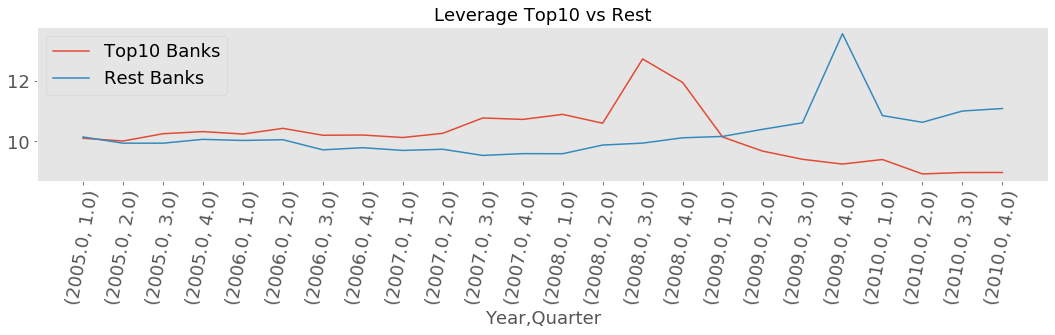

In [7]:
df.drop(df[df.equity<=0].index, inplace=True)
#calculate average of leverage per year and quarter
df_forLabels = df[(df.year>2004) & (df.year<2011) ]
df_mean = df[(df.year>2004) & (df.year<2011) ]
df_mean = df_mean.groupby(["year", "quarter"]).agg({"leverageRatio":"mean"})
df_mean.sort_values(by=["year", "quarter"])
#print(df_mean)
#sort values
df_forLabels.sort_values(by=["year", "quarter"])
df_forLabels = df_forLabels[["year", "quarter"]]
#create labels for graph
arrayIndex = []
df_forLabels = df_forLabels.drop_duplicates()
df_forLabels = df_forLabels[["year", "quarter"]].astype(int)
for row in df_forLabels.itertuples():
    dictRow = row._asdict()
    arrayIndex.append(str(dictRow["year"]) + "/" + str(dictRow["quarter"]))

#print(arrayIndex)
#make rssdid int
#df_mean.index = df_mean.index.astype(int)
# create mean values per year and quarter
arrayMeanLeverage = []
arrayTop10MeanLeverage = []
arrayRestMeanLeverage = []
year = 2005
quarter = 1
for i in range(6):
    #print(year)
    temp_df1 = df.copy()
    for y in range(4):
        temp_df2 = temp_df1[(temp_df1["quarter"]==quarter) & (temp_df1["year"]==year)]
        #top10 berechnen
        temp_df2.sort_values("assets", ascending=False, inplace=True)
        df_top10 = temp_df2.head(10)
        meanLeverage = df_top10.leverageRatio.mean()
        arrayTop10MeanLeverage.append(meanLeverage)
        #average leverage over rest banks
        df_rest = temp_df2.iloc[10:,:]
        meanLeverage = df_rest.leverageRatio.mean()
        arrayRestMeanLeverage.append(meanLeverage)
        #average leverage over all banks
        meanLeverage = temp_df2.leverageRatio.mean()
        arrayMeanLeverage.append(meanLeverage)
        quarter = quarter + 1
    year = year + 1
    quarter = 1
#create graph
fig, ax = plt.subplots(figsize=(15,5));
#ax.set_xticks(df_mean.index)

#create new dataframe with computed values
d2 = {"LeverageAllBanks" : arrayMeanLeverage, "LeverageTop10Banks" : arrayTop10MeanLeverage, "LeverageRestBanks" : arrayRestMeanLeverage}
temp_df = pd.DataFrame(data=d2, index=arrayIndex)
#print(d2)
#temp_df = pd.DataFrame(data=d2, index=arrayIndex)
ax.plot(temp_df.LeverageTop10Banks)
ax.plot(temp_df.LeverageRestBanks)
ax.grid()
ax.set_xticklabels(df_mean.index, rotation=80)
ax.legend(["Top10 Banks", "Rest Banks"])
ax.set_title("Leverage Top10 vs Rest")
ax.set_xlabel("Year,Quarter")
plt.tight_layout()
plt.savefig('LatexVorlage/graphs/Leverage/LeverageDistribution1_LeverageDetailCrisisTop10vsRest_0510.png')

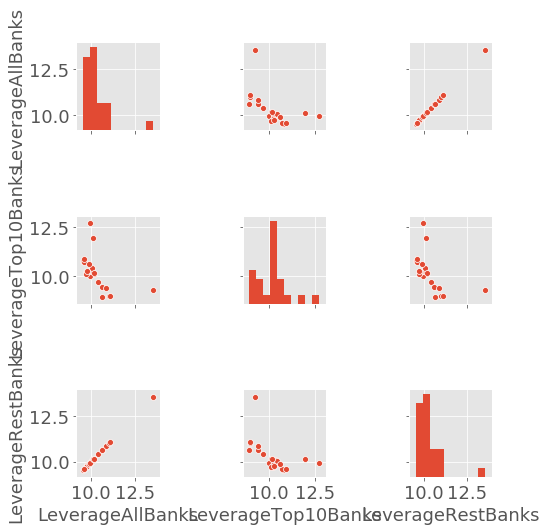

In [8]:
sns.pairplot(temp_df)

Analysing 2009/2 in detail.

In [9]:
temp_df1 = df.copy()
temp_df2 = temp_df1[(temp_df1["quarter"]==2) & (temp_df1["year"]==2009)]
temp_df2[temp_df2.leverageRatio < 5]
#temp_df2.leverageRatio.describe()


,year,quarter,assets,equity,leverageRatio,name
rssdid,,,,,,
1052958.0,2009.0,2.0,70108.0,14304.0,4.901286,NaN
1055584.0,2009.0,2.0,54205.0,12623.0,4.294146,NaN
1056125.0,2009.0,2.0,44527.0,12800.0,3.478672,NaN
1058101.0,2009.0,2.0,22932.0,4612.0,4.972246,NaN
1058138.0,2009.0,2.0,85683.0,17192.0,4.983888,NaN
1059519.0,2009.0,2.0,23236.0,5907.0,3.933638,NaN
1061594.0,2009.0,2.0,118710.0,24012.0,4.943778,NaN
1063516.0,2009.0,2.0,19413.0,5532.0,3.509219,NaN
1066946.0,2009.0,2.0,45677.0,11179.0,4.085965,NaN


Asset Distribution

In [10]:
import seaborn
import probscale

In [11]:
tips = seaborn.load_dataset("tips")
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
5,25.29,4.71,Male,No,Sun,Dinner,4
6,8.77,2.00,Male,No,Sun,Dinner,2
7,26.88,3.12,Male,No,Sun,Dinner,4
8,15.04,1.96,Male,No,Sun,Dinner,2
9,14.78,3.23,Male,No,Sun,Dinner,2


In [12]:
type(df.assets)

pandas.core.series.Series

C:\ProgramData\Anaconda3\lib\site-packages\probscale\probscale.py:44: RuntimeWarning: invalid value encountered in sign
  return numpy.sign(z) * numpy.sqrt(numpy.sqrt(_b**2 - _c) - _b)
C:\ProgramData\Anaconda3\lib\site-packages\probscale\probscale.py:32: RuntimeWarning: invalid value encountered in sign
  return numpy.sign(x) * numpy.sqrt(1.0 - numpy.exp(guts))


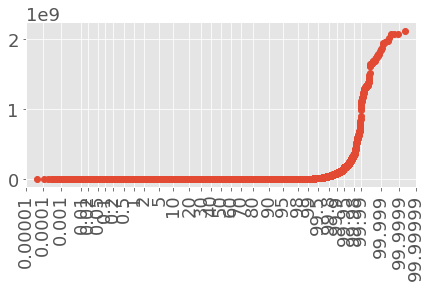

In [13]:
fig, ax = plt.subplots(figsize=(7, 3))
#ax.set_xticks(range(100))
#ax.set_xticklabels(range(0,100,1.0), rotation=60)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
probscale.probplot(df.assets, ax=ax)
seaborn.despine()

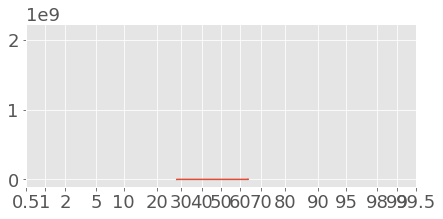

In [14]:
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(df.assets)
ax.set_xlim(0.5, 99.5)
ax.set_xscale('prob')

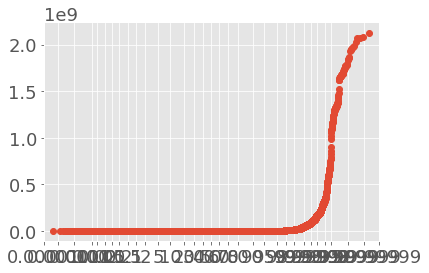

In [15]:
np.random.seed(0)
sample = np.random.normal(loc=4, scale=2, size=37)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
fig = probscale.probplot(df.assets)

seaborn.despine(fig=fig)


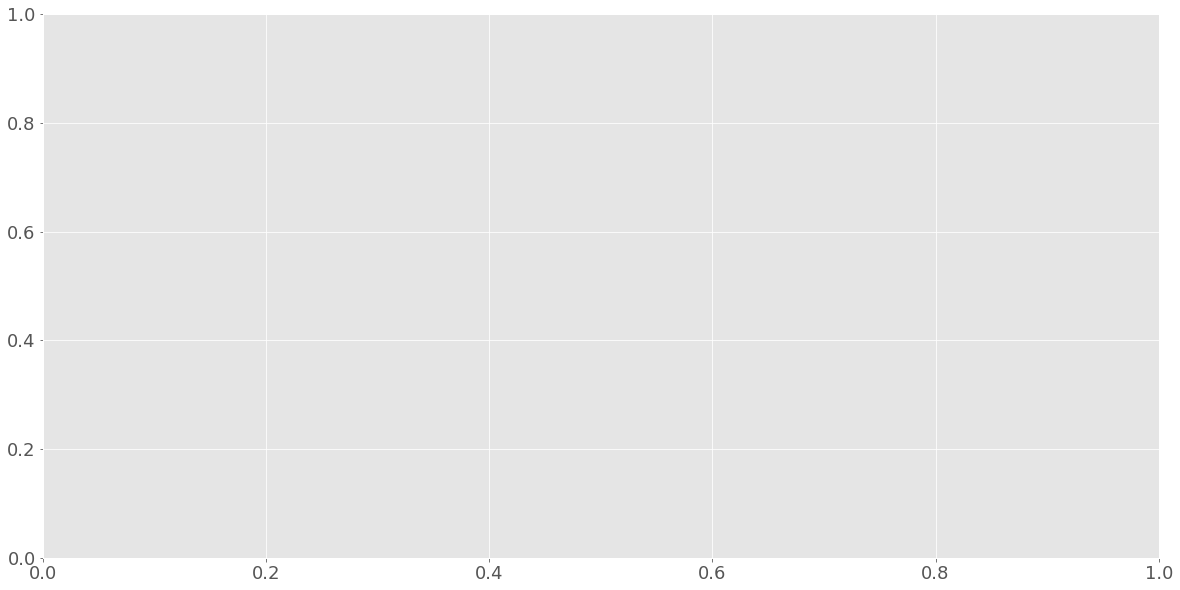

In [16]:
df_sorted = df.sort_values(by="assets", ascending=False)
df_sorted = df_sorted[(df_sorted.year==2005) & (df_sorted.quarter==4)]
df_top10 = df_sorted.head(10)
fig, ax = plt.subplots(figsize=(20,10))
